# House Prices - Advanced Regression Techniques
- Predict sales prices and practice feature engineering, RFs, and gradient boosting


### dataset
- train.csv - the training set
- test.csv - the test set
- data_description.txt - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
- sample_submission.csv - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

### Import Modules

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

from scipy.stats import skew

### Read row data

In [17]:
train = pd.read_csv('/Users/quzihanwu/Desktop/house-residen-den/row-data/train.csv')
# train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [18]:
test = pd.read_csv('/Users/quzihanwu/Desktop/house-residen-den/row-data/test.csv')

### Visualization

In [19]:
# train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

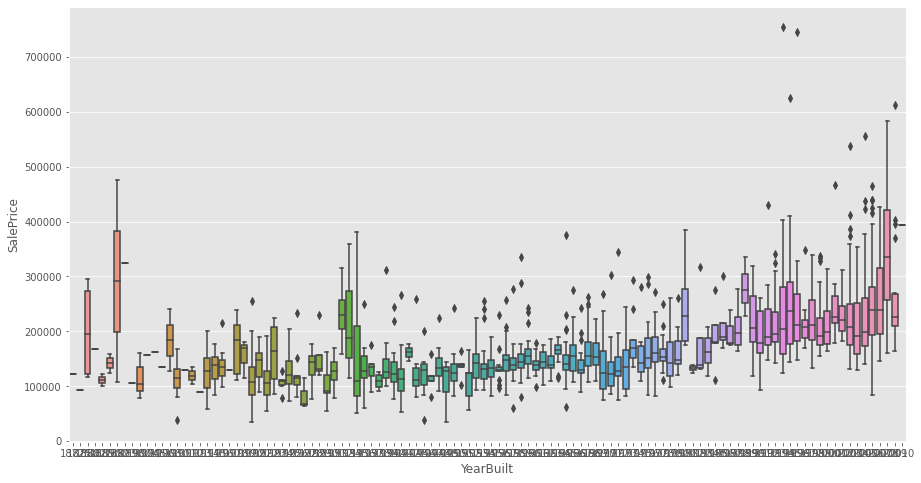

In [20]:
plt.figure(figsize = (15,8))
sns.boxplot(train.YearBuilt, train.SalePrice)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

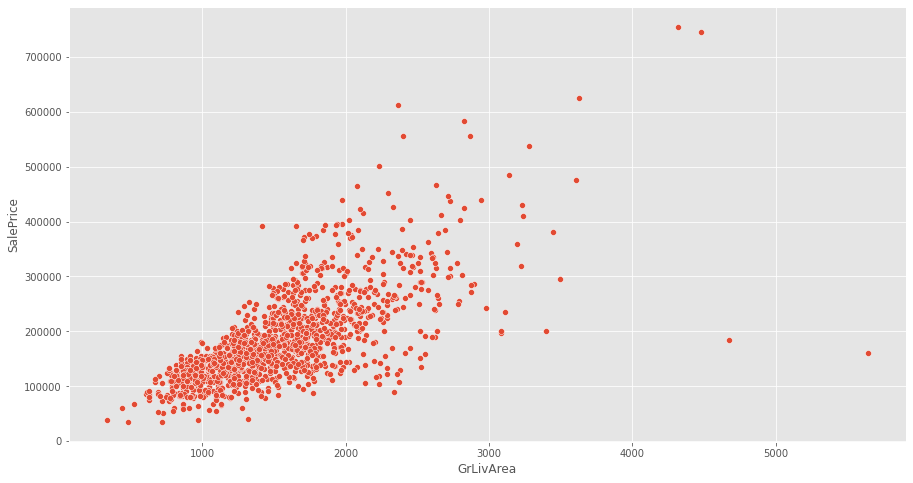

In [21]:
plt.figure(figsize= (15,8))
sns.scatterplot(train.GrLivArea, train.SalePrice)

### Data Cleaning 

In [24]:
# drop outliers
train.drop(train[(train['GrLivArea'] > 4000) & 
   (train['SalePrice'] <300000)].index, inplace=True)

# concat
full_data = pd.concat([train,test], ignore_index=True)
full_data.drop(['Id'], axis=1, inplace=True)
full_data.shape

(2917, 80)

In [27]:
none = full_data.isnull().sum()
none[none>0].sort_values(ascending = False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64